# AutoEncoder for Anomaly Detection

In this example, you will train an autoencoder to detect anomalies on
the ECG5000 dataset
http://www.timeseriesclassification.com/description.php?Dataset=ECG5000.
This dataset contains 5,000 Electrocardiograms, each with 140 data
points. You will use a simplified version of the dataset, where each
example has been labeled either 0 (corresponding to an abnormal rhythm),
or 1 (corresponding to a normal rhythm). Our goal is to identify
abnormal rhythms.

<img src="image\8be3ecb8450374755d0fcc23e18c7e1f7fe02450.png">

## Step 1: Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import layers, losses, optimizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

## Step 2: Download the dataset and Pre-process the data

In [2]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


tf.reduce_min / tf.reduce_max operations are to get the minimum and maximum value of a TensorFlow tensor. Then we normalize the data to [0,1] by dividing with (max_val - min_val).It is similar to dividing by 255 for image processing). Then apply tf.cast to cast the tensor to float type.

In [3]:
labels = raw_data[:, -1] # Last element contains the labels
data = raw_data[:, 0:-1] # Other data points are the ECG data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

## Step 3: Separate the normal rhythms from the abnormal rhythms.

Train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1

In [4]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## Step 4: Build the model and Training

In [5]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu")])
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [6]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
19/19 [==============================] - 5s 59ms/step - loss: 0.0500 - val_loss: 0.0434
Epoch 2/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0320 - val_loss: 0.0374
Epoch 3/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0256 - val_loss: 0.0353
Epoch 4/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0227 - val_loss: 0.0337
Epoch 5/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0206 - val_loss: 0.0327
Epoch 6/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0197 - val_loss: 0.0326
Epoch 7/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0193 - val_loss: 0.0312
Epoch 8/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0187 - val_loss: 0.0308
Epoch 9/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0179 - val_loss: 0.0298
Epoch 10/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0177 - val_loss: 0.0297
Epoch 11/

## Step 5: Set a threshold

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set (https://www.quora.com/What-is-meant-by-one-standard-deviation-away-from-the-mean). And choose a threshold value that is one standard deviation above the mean

<img src="image\19b5584ff3b352a189739ee78e4cb0d6453a1eb7.png">

In [7]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)

73/73 [==============================] - 1s 3ms/step


## Step 6: Define prediction function and Make prediction

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold (one standard deviation) from the normal training examples. We use Mean Absolute Error tf.keras.losses.mae to calculate the difference between reconstruction and our input.

In [8]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = losses.mae(reconstructions, data)
  return reconstructions, tf.math.less(loss, threshold)

In [9]:
reconstructions, predictions = predict(autoencoder, test_data, threshold)
print(classification_report(test_labels, predictions))
print("")
print(f"Accuracy = {accuracy_score(test_labels, predictions)}")
print(f"Precision = {precision_score(test_labels, predictions)}")
print(f"Recal = {recall_score(test_labels, predictions)}")

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       409
        True       1.00      0.90      0.95       591

    accuracy                           0.94      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.95      0.94      0.94      1000


Accuracy = 0.939
Precision = 1.0
Recal = 0.8967851099830795


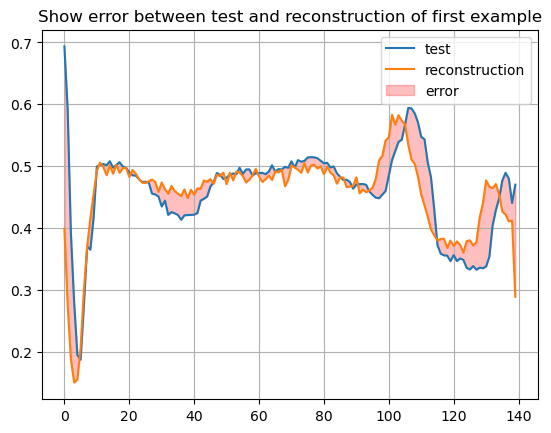

In [10]:
example_value = test_data[0]
reconstruct_value = reconstructions[0]
plt.grid(visible=True)
plt.plot(example_value, label='test')
plt.plot(reconstruct_value, label='reconstruction')
plt.fill_between(range(140), example_value, reconstruct_value, color='red', alpha=0.25, label='error')
plt.title('Show error between test and reconstruction of first example')
plt.legend()
plt.show()